In [ ]:
image_type = 'outdoor'

In [ ]:
img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]

In [ ]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights
%cd weights/
!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ..

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

In [ ]:
import bisect
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


def _compute_conf_thresh(data):
    dataset_name = data['dataset_name'][0].lower()
    if dataset_name == 'scannet':
        thr = 5e-4
    elif dataset_name == 'megadepth':
        thr = 1e-4
    else:
        raise ValueError(f'Unknown dataset: {dataset_name}')
    return thr


# --- VISUALIZATION --- #

def make_matching_figure(
        img0, img1, mkpts0, mkpts1, color,
        kpts0=None, kpts1=None, text=[], dpi=75, path=None):
    # Limit to 10 matches max
    n_matches = min(10, len(mkpts0))  # Get minimum of 10 or actual matches
    mkpts0 = mkpts0[:n_matches]  # Slice arrays
    mkpts1 = mkpts1[:n_matches]
    color = color[:n_matches]  # Slice colors to match

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=dpi)
    axes[0].imshow(img0, cmap='gray')
    axes[1].imshow(img1, cmap='gray')

    # Clean up axes
    for ax in axes:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.tight_layout(pad=1)

    # Draw keypoints (optional)
    if kpts0 is not None and kpts1 is not None:
        axes[0].scatter(kpts0[:, 0], kpts0[:, 1], c='w', s=2)
        axes[1].scatter(kpts1[:, 0], kpts1[:, 1], c='w', s=2)

    # Draw matches if they exist
    if n_matches > 0:
        # Transform points to figure coordinates
        fig.canvas.draw()
        transFigure = fig.transFigure.inverted()
        fkpts0 = transFigure.transform(axes[0].transData.transform(mkpts0))
        fkpts1 = transFigure.transform(axes[1].transData.transform(mkpts1))

        # Draw lines between matches
        fig.lines = [
            matplotlib.lines.Line2D(
                (fkpts0[i, 0], fkpts1[i, 0]),
                (fkpts0[i, 1], fkpts1[i, 1]),
                transform=fig.transFigure,
                c=color[i],
                linewidth=1
            ) for i in range(n_matches)
        ]

        # Draw match points
        axes[0].scatter(mkpts0[:, 0], mkpts0[:, 1], c=color, s=25)
        axes[1].scatter(mkpts1[:, 0], mkpts1[:, 1], c=color, s=25)

    # Add text annotations
    txt_color = 'k' if img0[:100, :200].mean() > 200 else 'w'
    fig.text(
        0.01, 0.99, '\n'.join(text), transform=axes[0].transAxes,
        fontsize=12, va='top', ha='left', color=txt_color)

    # Save or return
    if path:
        plt.savefig(str(path), bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        return fig

In [ ]:
matcher = LoFTR(config=default_cfg)
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cuda()

In [ ]:
# Rerun this cell (and below) if a new image pair is uploaded.
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

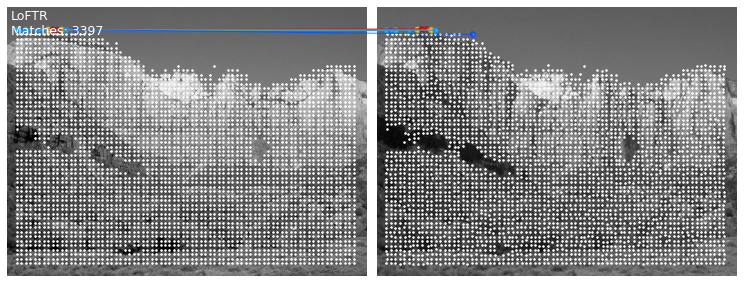

In [ ]:
# Draw
color = cm.jet(mconf, alpha=0.7)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

def count_files_in_subdirectories(root_dir):
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):  # Check if it's a directory
            file_count = sum([len(files) for _, _, files in os.walk(subdir_path)])
            if (file_count > 13):
              print('ERROR')
            print(f"{subdir}: {file_count} files")

In [ ]:
count_files_in_subdirectories('/content/gdrive/MyDrive/colab/patches')

i_ajuntament: 12 files
i_autannes: 12 files
i_bologna: 12 files
i_contruction: 12 files
i_castle: 12 files
i_brooklyn: 12 files
i_chestnuts: 12 files
i_bridger: 12 files
i_boutique: 12 files
i_books: 12 files
i_crownday: 12 files
i_crownnight: 12 files
i_dc: 12 files
i_fog: 12 files
i_fenis: 12 files
i_duda: 12 files
i_fruits: 13 files
i_greenhouse: 13 files
i_greentea: 12 files
i_gonnenberg: 12 files
i_dome: 12 files
i_kions: 12 files
i_indiana: 12 files
i_ktirio: 12 files
i_kurhaus: 12 files
i_nescafe: 12 files
i_leuven: 12 files
i_lionday: 12 files
i_melon: 12 files
i_nijmegen: 12 files
i_miniature: 12 files
i_londonbridge: 12 files
i_lionnight: 12 files
i_nuts: 12 files
i_objects: 12 files
i_parking: 12 files
i_pool: 12 files
i_partyfood: 12 files
i_porta: 12 files
i_salon: 12 files
i_resort: 12 files
i_pencils: 12 files
i_pinard: 12 files
i_school: 12 files
i_santuario: 12 files
i_ski: 11 files
i_smurf: 12 files
i_veggies: 12 files
i_toy: 12 files
i_whitebuilding: 12 files
i_table

In [ ]:
from tqdm import tqdm

In [ ]:
def auc(errors, thresholds):
    errors = np.array(errors)
    auc_values = []
    for thresh in thresholds:
        inliers = errors <= thresh
        auc_values.append(np.mean(inliers) * 100)  # Percentage
    return auc_values

In [ ]:
def evaluate_hpatches(model, ref_img, query_imgs, query_h_gt):

    errors = []
    img0_raw = cv2.resize(ref_img, (640, 480))
    img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
    # Get image dimensions (h, w) from ref_img
    if isinstance(ref_img, np.ndarray):  # OpenCV or NumPy array
        h, w = ref_img.shape[:2]  # For color (h, w, 3) or grayscale (h, w)
    else:  # PIL Image or other formats
        w, h = ref_img.size  # PIL uses (width, height) order

    ref_corners = np.array([[[0, 0], [w, 0], [w, h], [0, h]]], dtype=np.float32)

    for query_img, H_gt in zip(query_imgs, query_h_gt):
        # Step 1: Extract matches
        img1_raw = cv2.resize(query_img, (640, 480))
        img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
        batch = {'image0': img0, 'image1': img1}
        with torch.no_grad():
          model(batch)
          mkpts0 = batch['mkpts0_f'].cpu().numpy()
          mkpts1 = batch['mkpts1_f'].cpu().numpy()

        # Step 2: Estimate homography
        H_est, _ = cv2.findHomography(mkpts0, mkpts1, cv2.RANSAC, 3.0)

        # Step 3: Compute corner error
        corners_gt = cv2.perspectiveTransform(ref_corners, H_gt)
        if H_est is not None:  # Check if homography estimation succeeded
            corners_est = cv2.perspectiveTransform(ref_corners, H_est)
            error = np.mean(np.linalg.norm(corners_gt - corners_est, axis=1))
            errors.append(error)
        else:
            print("Homography estimation failed for a pair. Skipping...")
    return errors

In [ ]:
import os

In [ ]:
import os
import numpy as np
from PIL import Image  # or use cv2
import re

def natural_sort_key(s):
    """Key for natural sorting of filenames"""
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def load_data(folder_path):
    # Get all files and sort them naturally
    all_files = sorted(os.listdir(folder_path), key=natural_sort_key)

    ppm_files = []
    matrix_files = []

    # Separate ppm and matrix files
    for f in all_files:
        if f.endswith('.ppm'):
            ppm_files.append(f)
        elif '.' not in f:  # Matrix files have no extension
            matrix_files.append(f)

    # Sort both lists to ensure matching order
    ppm_files.sort(key=natural_sort_key)
    matrix_files.sort(key=natural_sort_key)

    # Load images
    images = []
    for ppm in ppm_files:
        img_path = os.path.join(folder_path, ppm)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        images.append(img)

    # Load matrices
    matrices = []
    for mat_file in matrix_files:
        mat_path = os.path.join(folder_path, mat_file)
        mat = np.loadtxt(mat_path)
        matrices.append(mat)

    return images, matrices

# Usage
folder_path = '/content/gdrive/MyDrive/colab/patches/v_wapping'
image_array, matrix_array = load_data(folder_path)

# Verify
print(f"Loaded {len(image_array)} images and {len(matrix_array)} matrices")
print("First matrix:")
print(matrix_array[0])

Loaded 6 images and 5 matrices
First matrix:
[[ 1.1901e+00 -4.8587e-02  1.0772e+02]
 [ 1.4488e-01  1.1926e+00 -1.2184e+02]
 [ 3.3622e-04  1.1241e-05  1.0001e+00]]


In [ ]:
root_dir = '/content/gdrive/MyDrive/colab/patches'

thresholds = [3, 5, 10]
all_errors = []

for subdir in tqdm(os.listdir(root_dir)):
  subdir_path = os.path.join(root_dir, subdir)
  images, query_h_gt = load_data(subdir_path)
  ref_img = images[0]
  query_imgs = images[1:]
  # print(np.shape(ref_img))
  err = evaluate_hpatches(matcher, ref_img, query_imgs, query_h_gt)
  all_errors += err

100%|██████████| 116/116 [06:46<00:00,  3.51s/it]


In [ ]:
# Step 4: Calculate AUC
auc_values = auc(all_errors, thresholds)
print(f"AUC @ {thresholds}px: {auc_values}")

AUC @ [3, 5, 10]px: [np.float64(40.86206896551724), np.float64(44.13793103448276), np.float64(47.06896551724138)]
